<a href="https://colab.research.google.com/github/picazio/COVID19-Studies/blob/master/R0_Svizzera_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://books.google.ch/books?hl=it&lr=&id=HT0--xXBguQC&oi=fnd&pg=PA27&dq=Anderson+R.M+May+R.M+Infectious+diseases+of+humans:+dynamics+and+control+1991+Oxford+University+Press+Oxford,+UK+&ots=IdodQMXOdl&sig=Q2B_WIEZF9aD5oUujKEkIzEvT_I&redir_esc=y#v=onepage&q&f=false

Chapter 2

General imports

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline


Epidemic shape function

In [0]:
#function definition
def epidemicshape(x,initInfected,Ntot,Vul,durationOfDisease,initR0) :
    
    b=((initR0*(float(Vul)/float(Ntot)))-1.)/durationOfDisease
    infected=initInfected*np.exp(b*x)
    
    return infected 

Region initial parameters

In [0]:
regione='Svizzera'

end=365*30
#end=26
c=1100
pred_x = list(range(0,end))

initInfected=1.
durationOfDisease=9.
Ntot=8570000.
Mortality=0.01

error=0.02

predshift=1
lockdown_shift=predshift

Definition of the full model function

In [0]:
def epidemic(initInfected_,Ntot_,durationOfDisease_,initR0,firstR0,secondR0,firstDay,secondDay,gap,pred_x) :

    vulnerables=Ntot_
    initialVulnerables=Ntot_
        
    infecteds=[]
    increment=[]
    exponent=[]
    effectiveR=[]
       
    for x in pred_x :
        
        r0fun=initR0
        initInf=initInfected_
        if x>firstDay :
            initInf=infecteds[firstDay-gap]
            r0fun=firstR0 
            
        if x>secondDay :
            initInf=infecteds[secondDay-gap]
            r0fun=secondR0
       
        infected=epidemicshape(x,initInf,Ntot_,vulnerables,durationOfDisease_,r0fun)
        vulnerables=vulnerables-infected
        infecteds.append((initialVulnerables-vulnerables))
        increment.append(infected)
        
    return infecteds

Now let's try to implement the fit to the data using the model we just implemented


In [5]:
url = "https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/covid19_fatalities_switzerland_openzh.csv"
df = pd.read_csv(url ,error_bad_lines=False)#, sep=',',error_bad_lines=False , engine='python')

df.head(42)

regioneSp='CH'
#regione='Emilia Romagna'
#dfSp=dfSp[dfSp['abbreviation_canton_and_fl']==regioneSp]
df = df.loc[:,['Date',regioneSp]]
df['deceduti']=df['CH']
df=df[df['deceduti']>0]
df['poisson_error']=df['deceduti'].apply(lambda x: np.sqrt(float(x)))

FMT = '%Y-%m-%d'
date = df['Date']
print(datetime.strptime("2020-01-01", FMT))
#df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )
df['Date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days  )

#dfSp['Cumulative']=dfSp[regioneSp].cumsum()



df.head(55)

2020-01-01 00:00:00


,Date,CH,deceduti,poisson_error
10,65,1.0,1.0,1.000000
11,66,1.0,1.0,1.000000
12,67,2.0,2.0,1.414214
13,68,2.0,2.0,1.414214
14,69,4.0,4.0,2.000000
15,70,7.0,7.0,2.645751
16,71,8.0,8.0,2.828427
17,72,8.0,8.0,2.828427
18,73,12.0,12.0,3.464102
19,74,19.0,19.0,4.358899


We need to define a function that can actually be fit to the data

In [0]:
day=df.shape[0]
pred_x = list(range(0,day))

Actual fitting section

In [7]:
#parameters ranges
bestR0=2.5
bestfirstR0=1.15
bestsecondR0=0.65
bestfirstDay=25
bestsecondDay=35
bestgap=14

r0Steps=0.01

#lists
initR0s=list(np.arange(bestR0*(1-0.03),bestR0*(1+0.03),r0Steps*2))
firstR0s=list(np.arange(bestfirstR0*(1-0.2),bestfirstR0*(1+0.2),r0Steps*2))
secondR0s=list(np.arange(bestsecondR0*(1-0.2),bestsecondR0*(1+0.2),r0Steps*2))
firstDays=list(np.arange(bestfirstDay-3,bestfirstDay+3,1))
secondDays=list(np.arange(bestsecondDay-3,bestsecondDay+3,1))
gaps=list(np.arange(bestgap-0,bestgap+1,1))
nloops=len(initR0s)*len(firstR0s)*len(secondR0s)*len(firstDays)*len(secondDays)*len(gaps)
print(nloops)
print(initR0s)
print(firstR0s)
print(secondR0s)
print(firstDays)
print(secondDays)
print(gaps)

86112
[2.425, 2.445, 2.465, 2.485, 2.505, 2.525, 2.545, 2.565]
[0.9199999999999999, 0.94, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08, 1.1, 1.12, 1.1400000000000001, 1.1600000000000001, 1.1800000000000002, 1.2000000000000002, 1.2200000000000002, 1.2400000000000002, 1.2600000000000002, 1.2800000000000002, 1.3000000000000003, 1.3200000000000003, 1.3400000000000003, 1.3600000000000003]
[0.52, 0.54, 0.56, 0.5800000000000001, 0.6000000000000001, 0.6200000000000001, 0.6400000000000001, 0.6600000000000001, 0.6800000000000002, 0.7000000000000002, 0.7200000000000002, 0.7400000000000002, 0.7600000000000002]
[22, 23, 24, 25, 26, 27]
[32, 33, 34, 35, 36, 37]
[14]


In [0]:
def testing(initInfected_,Ntot_,durationOfDisease_,pred_x, in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap,df) :
    #if (in_r0<0 or fr_r0<0 or sd_r0<0) :
    #    return 10000,-1,0
    #else :
        inf=epidemic(initInfected_,Ntot_,durationOfDisease_,in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap,pred_x)
        df['infecteds']=inf[:]
        df['scarti_w']=(df['deceduti']-df['infecteds'])*(df['deceduti']-df['infecteds'])/(df['poisson_error']+0.01)
        df['scarti']=(df['infecteds']-df['deceduti'])/df['deceduti']
        df['incrementi_dec']=df['deceduti'].diff()
        df['incrementi_inf']=df['infecteds'].diff()
        df['scarti_incrementi']=df['incrementi_inf']-df['incrementi_dec']
        #result[df['scarti_w'].sum()]=[in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap]
    
        #return df['scarti_w'].sum(),df['scarti'].sum(),df['scarti'].sum()/abs(df['scarti'].sum())
        #return df['scarti_w'].sum(),(df['infecteds'].sum()-df['deceduti'].sum())/df['deceduti'].sum(),df['scarti'].sum()/abs(df['scarti'].sum())
        #return df['scarti_w'].sum(),df['scarti_incrementi'].sum(),df['scarti'].sum()/abs(df['scarti'].sum())
        return df['scarti_w'].sum()
    
    
    
    

Now the actual loop of loops

In [9]:
#results={}
loop=0
min=10000000000
minPars=[]
for in_r0 in initR0s :
    for fr_r0 in firstR0s :
        for sd_r0 in secondR0s :
            for fr_day in firstDays :
                for sd_day in secondDays :
                    for Gap in gaps :
                        #par,_=testing(initInfected,Ntot,durationOfDisease,pred_x, in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap,df)
                        par=testing(initInfected,Ntot,durationOfDisease,pred_x, in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap,df)

                        if par<min :
                            min=par
                            minPars=[in_r0,fr_r0,sd_r0,fr_day,sd_day,Gap]
                            #print(min)
                            #print(minPars)
                        
                        loop=loop+1
                        if loop%10000==0 :
                            print(loop)
                            print(min)
                            print(minPars)
                        

10000
4468.647159763321
[2.425, 1.3200000000000003, 0.7600000000000002, 24, 32, 14]
20000
3860.5732610945392
[2.445, 1.3000000000000003, 0.7000000000000002, 24, 33, 14]
30000
2924.11159397386
[2.465, 1.1, 0.7200000000000002, 27, 33, 14]
40000
2053.04473600371
[2.485, 1.06, 0.6600000000000001, 27, 34, 14]
50000
1423.4275032445557
[2.505, 1.02, 0.5800000000000001, 27, 36, 14]
60000
1004.0597556853814
[2.525, 1.1, 0.7400000000000002, 26, 32, 14]
70000
689.5801013424515
[2.545, 1.06, 0.56, 26, 36, 14]
80000
681.2679397265887
[2.565, 1.04, 0.6000000000000001, 26, 35, 14]


In [10]:
print(minPars)

[2.565, 1.12, 0.6000000000000001, 25, 35, 14]


In [0]:
#minPars=[2.55,1.18,0.78,26,35,14]
def epidemic_incr(initInfected_,Ntot_,durationOfDisease_,initR0,firstR0,secondR0,firstDay,secondDay,gap,pred_x) :

    vulnerables=Ntot_
    initialVulnerables=Ntot_
        
    infecteds=[]
    increment=[]
    exponent=[]
    effectiveR=[]
       
    for x in pred_x :
        
        r0fun=initR0
        initInf=initInfected_
        if x>firstDay :
            initInf=infecteds[firstDay-gap]
            r0fun=firstR0 
            
        if x>secondDay :
            initInf=infecteds[secondDay-gap]
            r0fun=secondR0
       
        infected=epidemicshape(x,initInf,Ntot_,vulnerables,durationOfDisease_,r0fun)
        vulnerables=vulnerables-infected
        infecteds.append((initialVulnerables-vulnerables))
        increment.append(infected)
        
    return infecteds,increment

In [0]:
x = list(df.iloc[:,0]-65)
y = list(df.iloc[:,1])
yerror = list(df.iloc[:,1]*0.1)

#print(x)
#print(y)
pred_x = list(range(0,400))

shifted_pred=[]
for pred in pred_x :
    shifted_pred.append(pred)

error=0.02    
infec,increm=epidemic_incr(initInfected,Ntot,durationOfDisease,minPars[0],minPars[1],minPars[2],minPars[3],minPars[4],minPars[5],pred_x)
infecUP,incremUP=epidemic_incr(initInfected,Ntot,durationOfDisease,minPars[0]*(1+error),minPars[1]*(1+error),minPars[2]*(1+error),minPars[3]+1,minPars[4]+1,minPars[5]+1,pred_x)
infecDW,incremDW=epidemic_incr(initInfected,Ntot,durationOfDisease,minPars[0]*(1-error),minPars[1]*(1-error),minPars[2]*(1-error),minPars[3]-1,minPars[4]-1,minPars[5]-1,pred_x)

Plotting

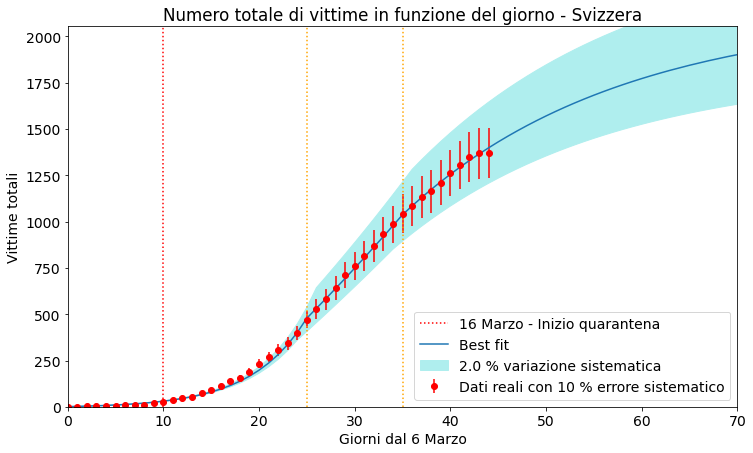

In [14]:
#pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

plt.axvline(10, 0, 1,label='16 Marzo - Inizio quarantena',linestyle=':', color='red')
plt.errorbar(x,y,yerr=yerror,label="Dati reali con 10 % errore sistematico",color="red",fmt='o')

errorUp=np.array(infecUP)
errorDw=np.array(infecDW)
yPred=np.array(infec)

#plt.plot(shifted_pred,infecteds[2.50],label="R0 = 2.5 senza contenimento",linestyle='--')
#plt.plot(shifted_pred,infecteds[2.25],label="R0 $\gtrapprox$ 1 - Zona di transizione dal 21-29 Marzo",linestyle='--')
plt.plot(shifted_pred,infec,label="Best fit")
plt.fill_between(shifted_pred, yPred-(yPred-errorDw), yPred+(errorUp-yPred),color="paleturquoise",label=str(error*100)+" % variazione sistematica")
#plt.axvline(27-14, 0, 1,label='8 Marzo - Inizio quarantena',linestyle=':', color='red')
#plt.axvline(26, 0, 1,linestyle=':',color='orange')
#plt.axvline(33, 0, 1,linestyle=':',color='orange')
plt.axvline(minPars[3], 0, 1,linestyle=':',color='orange')
plt.axvline(minPars[4], 0, 1,linestyle=':',color='orange')

plt.legend()
plt.title("Numero totale di vittime in funzione del giorno - "+regione)
plt.xlabel("Giorni dal 6 Marzo")
plt.ylabel("Vittime totali")
#plt.text(10, 3000, 'Grafico 4', fontdict=font)

#plt.ylim(3000,8000)
#plt.xlim(20,32)
#plt.grid()
plt.ylim(0,y[-1]*1.5)
plt.xlim(0,70)
#plt.yscale("log")

#plt.savefig('plots/R02p5_vs_realData_contenimento_'+regione+'.png')
plt.show()


In [0]:
limit=df.shape[0]
df['infecteds']=infec[:limit]
#print(df['infecteds'].pct_change())

dfnew=df.loc[:,['Date','deceduti','infecteds']]
dfnew['scarti']=dfnew['deceduti']-dfnew['infecteds']
dfnew['scarti_perc']=(dfnew['deceduti']-dfnew['infecteds'])*100/dfnew['deceduti']
dfnew['incrementi']=dfnew['deceduti'].diff()
#dfnew.head(45)

Scarti percentuali

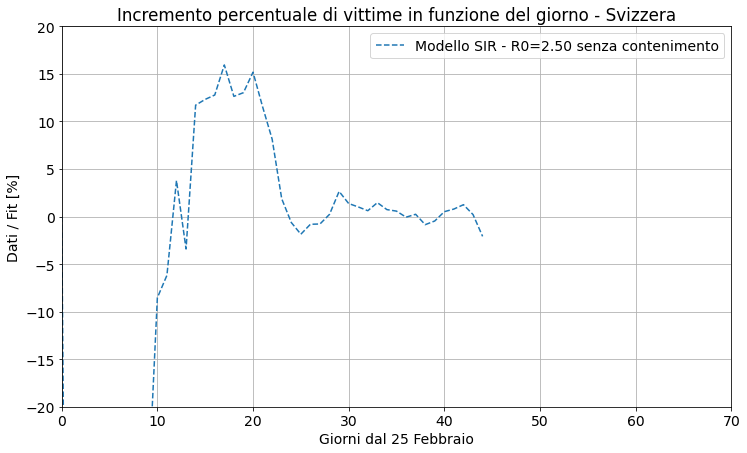

In [16]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

plt.plot(dfnew['Date']-65,dfnew['scarti_perc'],label="Modello SIR - R0=2.50"+" senza contenimento",linestyle='--')

plt.legend()
plt.title("Incremento percentuale di vittime in funzione del giorno - "+regione)
plt.xlabel("Giorni dal 25 Febbraio")
plt.ylabel("Dati / Fit [%]")
#plt.text(10, 3000, 'Grafico 4', fontdict=font)

#plt.ylim(3000,8000)
#plt.xlim(20,32)
plt.grid()
plt.ylim(-20,20)
plt.xlim(0,70)

#plt.savefig('R02p5_incrementipercentuali_up200_'+regione+'.png')
plt.show()

Daily increase

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
[nan, 0.0, 1.0, 0.0, 2.0, 3.0, 1.0, 0.0, 4.0, 7.0, 9.0, 7.0, 12.0, 6.0, 22.0, 16.0, 19.0, 27.0, 21.0, 32.0, 43.0, 34.0, 40.0, 36.0, 56.0, 71.0, 57.0, 53.0, 60.0, 72.0, 47.0, 54.0, 54.0, 66.0, 52.0, 58.0, 41.0, 49.0, 31.0, 46.0, 52.0, 42.0, 43.0, 21.0, 2.0]


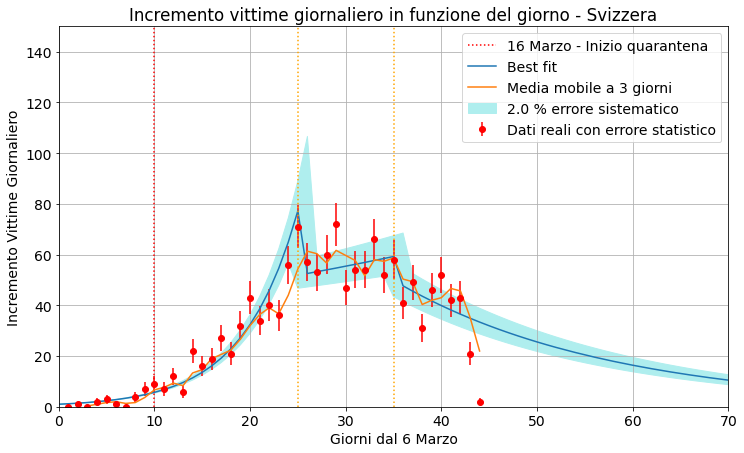

In [18]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

xaxis=np.array(pred_x)

errorUp=np.array(incremUP)
errorDw=np.array(incremDW)
yPred=np.array(increm)

x = list(dfnew.iloc[:,0]-65)
y = list(dfnew.iloc[:,5])
yerror = list(np.sqrt(dfnew.iloc[:,5]))

print(x)
print(y)

plt.axvline(10, 0, 1,label='16 Marzo - Inizio quarantena',linestyle=':', color='red')
plt.errorbar(x,y,yerr=yerror,label="Dati reali con errore statistico",color="red",fmt='o')

plt.plot(xaxis,increm,label="Best fit")

plt.fill_between(xaxis, yPred-(yPred-errorDw), yPred+(errorUp-yPred),color="paleturquoise",label=str(error*100)+" % errore sistematico")
plt.plot(x,list(dfnew.iloc[:,5].rolling(3).sum()/3.), label='Media mobile a 3 giorni')

#for r0 in initR0 :
#    if r0==2.25 :
#            plt.plot(pred_x,increment[r0],label="R0=2.5 senza contenimento")
#    else :
#            plt.plot(pred_x,increment[r0],label="Incremento R0="+str(r0)+" con contenimento da giorno 30")
#plt.plot(pred_x,increment[1.00],label="Incremento R0=1.00")

#plt.plot(pred_x,increment,label="Incremento R0=2.5",color="blue")
plt.legend()
plt.title("Incremento vittime giornaliero in funzione del giorno - "+regione)
plt.xlabel("Giorni dal 6 Marzo")
plt.ylabel("Incremento Vittime Giornaliero")
#plt.ylim(0,2000)
plt.axvline(minPars[3], 0, 1,linestyle=':',color='orange')
plt.axvline(minPars[4], 0, 1,linestyle=':',color='orange')

#plt.xlim(0,200)
plt.ylim(0,150)
plt.xlim(0,70)
plt.grid()

#plt.savefig('plots/IncrementoVittime_Vs_R0_contenimento_'+regione+'.png')

#print(increment[2.5])

plt.show()